# Classification of Benign and Malignant Moles

## Annie, Julia Bloom, Nabila Lotayef

In [10]:
# import necessary packages
from PIL import Image
import pandas as pd
import glob
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, color
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import Sequence
from keras.optimizers import SGD
from PIL import Image, ImageFilter
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
!ls "/content/drive/My Drive/ML Project/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Final-Project_AnnieBloomLotayef.ipynb  Preview	test_224  train_224


## I. Image Pre-Processing: Augmentation

Data source: https://www.isic-archive.com/#!/topWithHeader/onlyHeaderTop/gallery

Using the filters, we selected images that were classified as Benign or Malignant, and had metadata available for both Family History of Melanoma and Personal History of Melanoma.

Our dataset consisted of 1149 images of malignant moles and 348 images of malignant moles. The original images were very large in size, so we resized them to 150x150 pixels. We reserved 149 images from each class for our test set by simply taking the last 149 images in each set (since there was no reason to think the images were listed in any necessary order). In our train set, there remained 1000 benign images and 199 malignant. In order to achieve a more balanced training dataset, we performed manual image augmentation to create an additional 801 malignant images.

In [ ]:
# define functions for various transformations

# create random rotation function
def random_rotation(image_array: ndarray):
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

# create random noise function
def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

# create horizontal flip function
def horizontal_flip(image_array: ndarray):
    return image_array[:, ::-1]

# build dictionary of all three transformation functions
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

# assign directories and number of augmented images desired

# assign directories and number of augmented images desired
folder_path =     '/content/drive/My Drive/ML Project/train_224/malignant'
 # where the images you want to augment are
new_folder_path = '/content/drive/My Drive/ML Project/Preview' # save in a new folder first
num_files_desired = 800 # number of images you want to generate / NOTE: use (Number desired - 1)

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

In [ ]:
# create augmentation images
num_generated_files = 0
while num_generated_files <= num_files_desired:
    image_path = random.choice(images) # randomly select an image
    image_to_transform = sk.io.imread(image_path) # read the image
    num_transformations_to_apply = random.randint(1, len(available_transformations)) # randomly apply transformations

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1
    new_file_path = '%s/augmented_image_%s.jpg' % (new_folder_path, num_generated_files)
    io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

## II. Training and Testing Models

### 1. Convolutional Neural Network - No Augmentation

We train a simple neural network with three layers on our train data, and validate on our test. We normalize the images and shuffle the training data prior to training. We found that the model performed was quickly subject to overfitting, and we were hesitant to rely on the results given the limited amount of data and with the understanding that deep learning methods generally perform better with larger amounts of data.

In [12]:
# assign variables/directories
nb_train_samples = 2000
nb_validation_samples = 298
epochs = 20
batch_size = 20
img_width, img_height = 150, 150

train_data_dir = '/content/drive/My Drive/ML Project/train_224' # train data - two subfolders (benign, malignant)
validation_data_dir = '/content/drive/My Drive/ML Project/test_224' # test data - two subfolders (benign, malignant)  

# create generators, normalizing the images
train_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True, # shuffle data to prevent prediction of singular class
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 2010 images belonging to 2 classes.
Found 298 images belonging to 2 classes.


In [ ]:
# import necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.python.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras.optimizers import SGD

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# build and train model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model1 = model.fit_generator(
            train_generator,
            steps_per_epoch=(nb_train_samples // batch_size),
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples)

model.save_weights('model1.h5')

Epoch 1/20
100/100 [==============================] - 159s 2s/step - loss: 0.6127 - accuracy: 0.6700 - val_loss: 0.7922 - val_accuracy: 0.5159
Epoch 2/20
100/100 [==============================] - 163s 2s/step - loss: 0.5529 - accuracy: 0.6920 - val_loss: 0.7195 - val_accuracy: 0.5637
Epoch 3/20
100/100 [==============================] - 162s 2s/step - loss: 0.5146 - accuracy: 0.7325 - val_loss: 0.7665 - val_accuracy: 0.5692
Epoch 4/20
100/100 [==============================] - 163s 2s/step - loss: 0.4758 - accuracy: 0.7555 - val_loss: 0.6364 - val_accuracy: 0.6466
Epoch 5/20
100/100 [==============================] - 163s 2s/step - loss: 0.4477 - accuracy: 0.7755 - val_loss: 0.8406 - val_accuracy: 0.5660
Epoch 6/20
100/100 [==============================] - 159s 2s/step - loss: 0.4351 - accuracy: 0.7915 - val_loss: 0.8419 - val_accuracy: 0.5527
Epoch 7/20
100/100 [==============================] - 158s 2s/step - loss: 0.3976 - accuracy: 0.8095 - val_loss: 0.7860 - val_accuracy: 0.5655

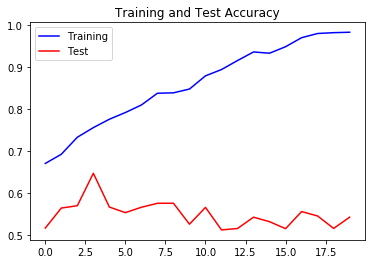

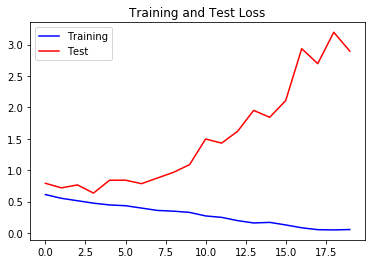

In [ ]:
acc = model1.history['accuracy']
val_acc = model1.history['val_accuracy']
loss = model1.history['loss']
val_loss = model1.history['val_loss']
 
epochs = range(len(acc))

# plot accuracy
plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Test')
plt.title('Training and Test Accuracy')
plt.legend()
 
plt.figure()
 
# plot loss
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Test')
plt.title('Training and Test Loss')
plt.legend()

### 2. Convolutional Neural Network - with Real Time Augmentation

We use the same model as above, but use additional real-time augmentation. The results were poor, never breaking past ~60% validation accuracy, and ~80% accuracy on the training set, and incredibly variable with each run. This is despite testing various epochs (5, 10, 15, 20, 50, and 80), using various activation methods for each layer (softmax instead of sigmoid, selu instead of relu), adding regularizers, and adjusting the optimization method (Adam instead of SGD, adjusting the level of loss).

In [ ]:
# assign variables/directories
nb_train_samples = 2000
nb_validation_samples = 298
epochs = 20
batch_size = 20
img_width, img_height = 150, 150

train_data_dir = 'C:/Users/nlotaye/Desktop/School/MSCA 31009/train'
validation_data_dir = 'C:/Users/nlotaye/Desktop/School/MSCA 31009/test'   

# create generators
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    width_shift_range=0.4,
    height_shift_range=0.4)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 298 images belonging to 2 classes.


In [ ]:
# import necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.python.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import EarlyStopping
#keras.regularizers.l1(0.01)
#keras.regularizers.l2(0.01)
#keras.regularizers.l1_l2(l1=0.01, l2=0.01)

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
# early stopping function for longer epoch runs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# build and train model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
#model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model2 = model.fit_generator(
            train_generator,
            steps_per_epoch=(nb_train_samples // batch_size),
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples)
            #callbacks=[es]

model.save_weights('model2.h5')

Epoch 1/20
100/100 [==============================] - 163s 2s/step - loss: 0.6906 - accuracy: 0.5925 - val_loss: 0.7026 - val_accuracy: 0.5198
Epoch 2/20
100/100 [==============================] - 164s 2s/step - loss: 0.6003 - accuracy: 0.6370 - val_loss: 0.7018 - val_accuracy: 0.5130
Epoch 3/20
100/100 [==============================] - 161s 2s/step - loss: 0.6008 - accuracy: 0.6420 - val_loss: 0.7257 - val_accuracy: 0.5029
Epoch 4/20
100/100 [==============================] - 163s 2s/step - loss: 0.5971 - accuracy: 0.6445 - val_loss: 0.7698 - val_accuracy: 0.5098
Epoch 5/20
100/100 [==============================] - 161s 2s/step - loss: 0.6062 - accuracy: 0.6375 - val_loss: 0.7190 - val_accuracy: 0.4961
Epoch 6/20
100/100 [==============================] - 157s 2s/step - loss: 0.5956 - accuracy: 0.6375 - val_loss: 0.7074 - val_accuracy: 0.5098
Epoch 7/20
100/100 [==============================] - 162s 2s/step - loss: 0.5983 - accuracy: 0.6345 - val_loss: 0.7032 - val_accuracy: 0.5064

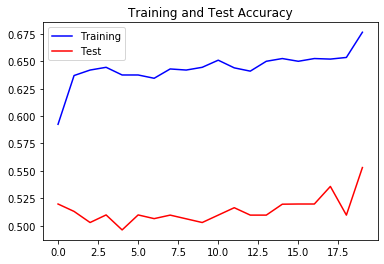

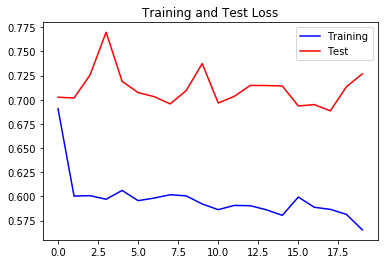

In [ ]:
acc = model2.history['accuracy']
val_acc = model2.history['val_accuracy']
loss = model2.history['loss']
val_loss = model2.history['val_loss']
 
epochs = range(len(acc))

# plot accuracy
plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Test')
plt.title('Training and Test Accuracy')
plt.legend()
 
plt.figure()
 
# plot loss
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Test')
plt.title('Training and Test Loss')
plt.legend()

### 2. Transfer Learning

Given our limited dataset, we wanted to incorporate the images from the ImageNet dataset via the VGG16 and VGG19 pre-trained network.

In [ ]:
# import necessary packages
import os
import glob

from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import adam
from keras.preprocessing.image import ImageDataGenerator  

In [25]:
# assign variables/directories
num_classes = 2  
batch_size = 20
epochs = 20
last_layer_classifier = num_classes - 1
cl_mode = 'binary'
nb_train_samples = 2000
nb_validation_samples = 298
classifier_loss = 'binary_crossentropy'
img_width, img_height = 224, 224

train_data_dir = '/content/drive/My Drive/ML Project/train_224' # train data - two subfolders (benign, malignant)
validation_data_dir = '/content/drive/My Drive/ML Project/test_224' # test data - two subfolders (benign, malignant)  

# create generators
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    width_shift_range=0.4,
    height_shift_range=0.4)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 2010 images belonging to 2 classes.
Found 298 images belonging to 2 classes.


# **VGG 16 Architecture**

In [15]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# import VGG16 pre-trained network
model = VGG16(weights='imagenet', include_top=True)
x = Dense(last_layer_classifier, activation='softmax', name='predictions')(model.layers[-2].output)
my_model = Model(input=model.input, output=x)
print(my_model.summary())

553467904/553467096 [==============================] - 12s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

In [ ]:
# define list of callbacks
weight_name = 'image_classification_model_weights.h5'
checkpoint = ModelCheckpoint(weight_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='min')
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', cooldown=0,
                           min_lr=0.000000001)
callbacks_list = [checkpoint, lr, early]

In [26]:
# build and train model
from keras.optimizers import adam
classifier_loss = 'binary_crossentropy'

adam = adam(lr=0.001)
my_model.compile(optimizer=adam, loss=classifier_loss, metrics=['accuracy'])
history = my_model.fit_generator(train_generator, steps_per_epoch=(nb_train_samples // batch_size), epochs=epochs,
                                                                     validation_data=validation_generator,
                                                                     validation_steps=(nb_train_samples // batch_size),
                                                                         callbacks=callbacks_list, shuffle=True,
                                                                         verbose=1)

Epoch 1/20
100/100 [==============================] - 39s 387ms/step - loss: 8.0585 - acc: 0.4945 - val_loss: 8.4203 - val_acc: 0.4718

Epoch 00001: val_loss did not improve from 7.62601
Epoch 2/20
100/100 [==============================] - 35s 353ms/step - loss: 7.9635 - acc: 0.5005 - val_loss: 8.0274 - val_acc: 0.4965

Epoch 00002: val_loss did not improve from 7.62601
Epoch 3/20
100/100 [==============================] - 35s 348ms/step - loss: 8.0747 - acc: 0.4935 - val_loss: 7.6260 - val_acc: 0.5217

Epoch 00003: val_loss did not improve from 7.62601
Epoch 4/20
100/100 [==============================] - 35s 353ms/step - loss: 7.9871 - acc: 0.4990 - val_loss: 8.4203 - val_acc: 0.4718

Epoch 00004: val_loss did not improve from 7.62601
Epoch 5/20
100/100 [==============================] - 35s 349ms/step - loss: 7.9633 - acc: 0.5005 - val_loss: 8.0274 - val_acc: 0.4965

Epoch 00005: val_loss did not improve from 7.62601
Epoch 6/20
100/100 [==============================] - 35s 348ms/s

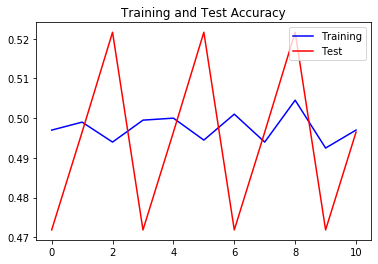

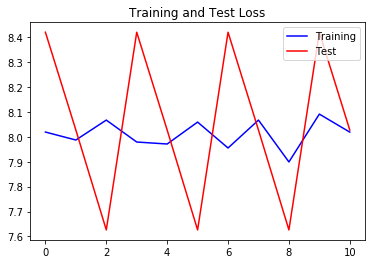

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

# plot accuracy
plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Test')
plt.title('Training and Test Accuracy')
plt.legend()
 
plt.figure()
 
# plot loss
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Test')
plt.title('Training and Test Loss')
plt.legend()

## **VGG 19 Architecture**

In [64]:
from keras.applications.vgg19 import VGG19
from keras.optimizers import SGD
from keras.models import Sequential, Model 
classifier_loss = 'binary_crossentropy'

model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train.
for layer in model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)
# compile the model 
model_final.compile(loss =classifier_loss, optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Train the model 
model_final=model_final.fit_generator(train_generator, steps_per_epoch=(nb_train_samples // batch_size), epochs=10,
                                                                     validation_data=validation_generator,
                                                                     validation_steps=(nb_train_samples // batch_size),
                                                                         callbacks=callbacks_list, shuffle=True,
                                                                         verbose=1)

Epoch 1/10
100/100 [==============================] - 38s 384ms/step - loss: 8.0110 - acc: 0.4975 - val_loss: 8.4203 - val_acc: 0.4718

Epoch 00001: val_loss did not improve from 7.62601
Epoch 2/10
100/100 [==============================] - 34s 340ms/step - loss: 7.9713 - acc: 0.5000 - val_loss: 8.0274 - val_acc: 0.4965

Epoch 00002: val_loss did not improve from 7.62601
Epoch 3/10
100/100 [==============================] - 34s 339ms/step - loss: 8.0906 - acc: 0.4925 - val_loss: 7.6260 - val_acc: 0.5217

Epoch 00003: val_loss did not improve from 7.62601
Epoch 4/10
100/100 [==============================] - 34s 335ms/step - loss: 8.0429 - acc: 0.4955 - val_loss: 8.4203 - val_acc: 0.4718

Epoch 00004: val_loss did not improve from 7.62601
Epoch 5/10
100/100 [==============================] - 34s 338ms/step - loss: 7.9392 - acc: 0.5020 - val_loss: 8.0274 - val_acc: 0.4965

Epoch 00005: val_loss did not improve from 7.62601
Epoch 6/10
100/100 [==============================] - 33s 335ms/s

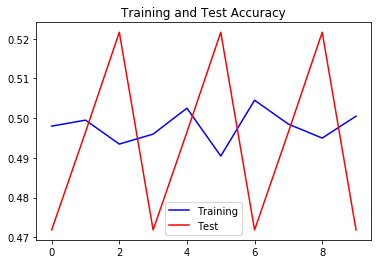

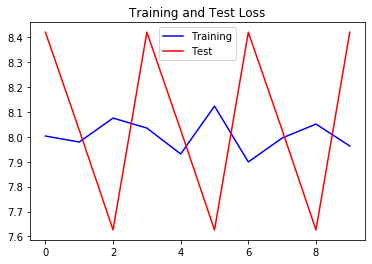

In [65]:
acc = model_final.history['acc']
val_acc = model_final.history['val_acc']
loss = model_final.history['loss']
val_loss = model_final.history['val_loss']
 
epochs = range(len(acc))

# plot accuracy
plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Test')
plt.title('Training and Test Accuracy')
plt.legend()
 
plt.figure()
 
# plot loss
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Test')
plt.title('Training and Test Loss')
plt.legend()

## **VGG 16 with Conv layer** 

In [59]:

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape= (img_width, img_height, 3))

for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    # Create the model
model =Sequential() 
# Add the vgg convolutional base model
model.add(vgg_conv) 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))


# build and train model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_2 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 394272)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               50466944  
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                

In [60]:
from keras.optimizers import Adam

# Save the model'

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

vgg3 = model.fit_generator(
            train_generator,
            steps_per_epoch=(nb_train_samples // batch_size),
            epochs=10,
            validation_data=validation_generator,
           validation_steps=nb_validation_samples,
            callbacks=callbacks_list)

model.save_weights('modeltransfer3.h5')


Epoch 1/10
100/100 [==============================] - 39s 391ms/step - loss: 8.0188 - acc: 0.4970 - val_loss: 8.0762 - val_acc: 0.4934

Epoch 00001: val_loss did not improve from 7.62601
Epoch 2/10
100/100 [==============================] - 36s 359ms/step - loss: 8.0748 - acc: 0.4935 - val_loss: 8.0789 - val_acc: 0.4932

Epoch 00002: val_loss did not improve from 7.62601
Epoch 3/10
100/100 [==============================] - 36s 365ms/step - loss: 7.9873 - acc: 0.4990 - val_loss: 8.0789 - val_acc: 0.4932

Epoch 00003: val_loss did not improve from 7.62601
Epoch 4/10
100/100 [==============================] - 36s 359ms/step - loss: 8.0189 - acc: 0.4970 - val_loss: 8.0520 - val_acc: 0.4949

Epoch 00004: val_loss did not improve from 7.62601
Epoch 5/10
100/100 [==============================] - 36s 362ms/step - loss: 7.9473 - acc: 0.5015 - val_loss: 7.9712 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 7.62601
Epoch 6/10
100/100 [==============================] - 36s 359ms/s

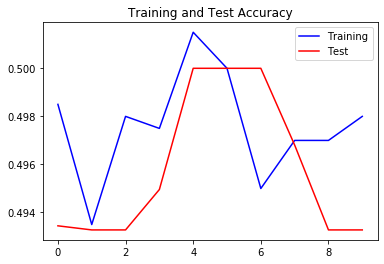

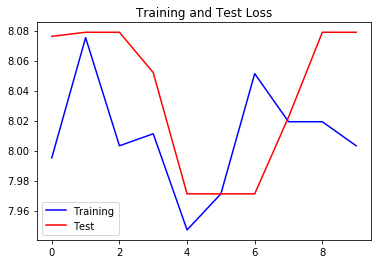

In [62]:
acc = vgg3.history['acc']
val_acc = vgg3.history['val_acc']
loss = vgg3.history['loss']
val_loss = vgg3.history['val_loss']
 
epochs = range(len(acc))

# plot accuracy
plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Test')
plt.title('Training and Test Accuracy')
plt.legend()
 
plt.figure()
 
# plot loss
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Test')
plt.title('Training and Test Loss')
plt.legend()

We initially expected significantly improved results through transfer learning, so we did some initial research on the effect of transfer learning on medical image classification. We found multiple studies hypothesizing why transfer learning is less effective with the classification of medical images than natural images:
While there is medical imaging data available within ImageNet, it is difficult to apply transfer learning to medical imaging because there are fundamental differences in data sizes, features and task specifications
 A performance evaluation on two large scale medical imaging tasks shows that surprisingly, transfer offers little benefit to performance, and simple, lightweight models can perform comparably to ImageNet architectures. Investigating the learned representations and features, we find that some of the differences from transfer learning are due to the over-parametrization of standard models rather than sophisticated feature reuse. 


### 3. Non-Image Data

We wanted to try a few models on the metadata features only, in order to understand their value within an image classification model. The first few steps outlined below show how we imported the .json files into a usable dataframe, then some data exploration and graphs. Then we move into the individual models (Logistic Regression, Random Forest, and SVM). Each model was built using GridSearchCV with 5 cross-validation samples.

In [ ]:
# import necessary packages
import os, json
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [ ]:
# import .json files and build dataframe
path_to_json = '/Users/9048550/Desktop/json_files/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

jsons_data = pd.DataFrame(columns=['Name', 'Benign_Malignant', 'Age', 'Sex', 'Family_History', 'Personal_History', 'Size'])

for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
        
        Name = json_text['name']
        Benign_Malignant = json_text['meta']['clinical']['benign_malignant']
        Age = json_text['meta']['clinical']['age_approx']
        Sex = json_text['meta']['clinical']['sex']
        Family_History = json_text['meta']['clinical']['family_hx_mm']
        Personal_History = json_text['meta']['clinical']['personal_hx_mm']
        Size = json_text['meta']['clinical']['clin_size_long_diam_mm']
        jsons_data.loc[index] = [Name, Benign_Malignant, Age, Sex, Family_History, Personal_History, Size]

jsons_data.head()

,Name,Benign_Malignant,Age,Sex,Family_History,Personal_History,Size
0,ISIC_0010426,malignant,70,female,False,True,10.0
1,ISIC_0010099,benign,80,female,True,True,6.0
2,ISIC_0010133,benign,60,female,False,True,8.0
3,ISIC_0009938,benign,35,male,False,True,5.0
4,ISIC_0009892,benign,40,female,False,False,3.0


In [ ]:
# summarize and check for missing data
jsons_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 0 to 693
Data columns (total 7 columns):
Name                694 non-null object
Benign_Malignant    694 non-null object
Age                 694 non-null object
Sex                 694 non-null object
Family_History      694 non-null object
Personal_History    694 non-null object
Size                694 non-null float64
dtypes: float64(1), object(6)
memory usage: 43.4+ KB


In [ ]:
# verify balanced dataset
jsons_data['Benign_Malignant'].value_counts()

benign       347
malignant    347
Name: Benign_Malignant, dtype: int64

In [ ]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# clean the final dataframe (drop unnecessary columns, assign dummy variables, add classifier column)
jsons_data['malignant'] = np.nan
jsons_data.malignant[jsons_data.Benign_Malignant == 'malignant'] = 1
jsons_data.malignant[jsons_data.Benign_Malignant == 'benign'] = 0

jsons_data['female'] = np.nan
jsons_data.female[jsons_data.Sex == 'female'] = 1
jsons_data.female[jsons_data.Sex == 'male'] = 0

jsons_data['Family_History'] = jsons_data['Family_History']*1
jsons_data['Personal_History'] = jsons_data['Personal_History']*1

jsons_data = jsons_data[['Name', 'Age', 'female', 'Family_History', 'Personal_History', 'Size', 'malignant']]

jsons_data.set_index('Name', inplace=True)

jsons_data['malignant classifier'] = np.nan

jsons_data.head()

,Age,female,Family_History,Personal_History,Size,malignant,malignant classifier
Name,,,,,,,
ISIC_0010426,70,1.0,0,1,10.0,1.0,NaN
ISIC_0010099,80,1.0,1,1,6.0,0.0,NaN
ISIC_0010133,60,1.0,0,1,8.0,0.0,NaN
ISIC_0009938,35,0.0,0,1,5.0,0.0,NaN
ISIC_0009892,40,1.0,0,0,3.0,0.0,NaN


In [ ]:
# explore age feature
jsons_data = jsons_data.astype({"Age":'int64'})
jsons_data['Age'].describe()

count    694.000000
mean      55.972622
std       19.318044
min        0.000000
25%       45.000000
50%       60.000000
75%       70.000000
max       85.000000
Name: Age, dtype: float64

In [ ]:
# explore size feature 
jsons_data['Size'].describe()

count    694.000000
mean       8.344380
std        6.800504
min        1.000000
25%        5.000000
50%        7.000000
75%       10.000000
max      100.000000
Name: Size, dtype: float64

In [ ]:
# explore gender split
jsons_data['female'].value_counts()

0.0    381
1.0    313
Name: female, dtype: int64

In [ ]:
# explore family history split
jsons_data['Family_History'].value_counts()

0    580
1    114
Name: Family_History, dtype: int64

In [ ]:
# explore personal history split
jsons_data['Personal_History'].value_counts()

0    461
1    233
Name: Personal_History, dtype: int64

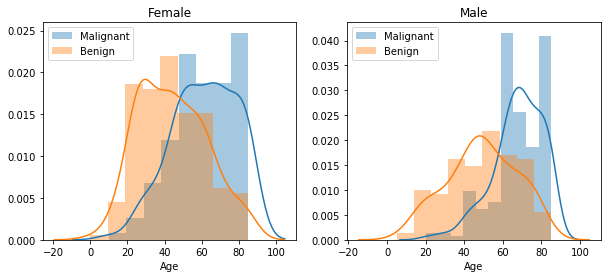

In [ ]:
# plot distributions (sex and age)
women = jsons_data[jsons_data['female']==1]
men = jsons_data[jsons_data['female']==0]
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

ax = sns.distplot(women[women['malignant']==1].Age.dropna(), ax = axes[0], label='Malignant')
ax = sns.distplot(women[women['malignant']==0].Age.dropna(),  ax = axes[0], label='Benign')
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['malignant']==1].Age.dropna(), ax = axes[1], label='Malignant')
ax = sns.distplot(men[men['malignant']==0].Age.dropna(), ax = axes[1], label='Benign')
ax.legend()
_ = ax.set_title('Male')

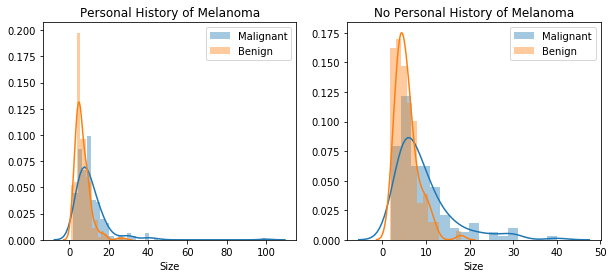

In [ ]:
# plot distributions (personal history and size)
ph_0 = jsons_data[jsons_data['Personal_History']==0]
ph_1 = jsons_data[jsons_data['Personal_History']==1]
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

ax = sns.distplot(ph_0[ph_0['malignant']==1].Size.dropna(), ax = axes[0], label='Malignant')
ax = sns.distplot(ph_0[ph_0['malignant']==0].Size.dropna(),  ax = axes[0], label='Benign')
ax.legend()
ax.set_title('Personal History of Melanoma')
ax = sns.distplot(ph_1[ph_1['malignant']==1].Size.dropna(), ax = axes[1], label='Malignant')
ax = sns.distplot(ph_1[ph_1['malignant']==0].Size.dropna(), ax = axes[1], label='Benign')
ax.legend()
_ = ax.set_title('No Personal History of Melanoma')

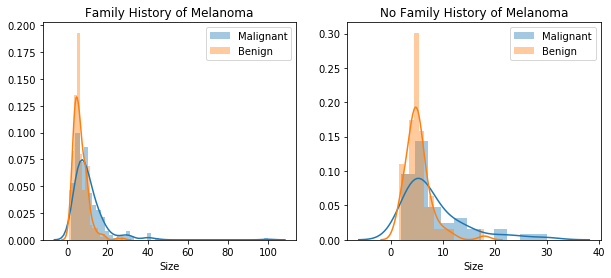

In [ ]:
# plot distributions (family history and size)
fh_0 = jsons_data[jsons_data['Family_History']==0]
fh_1 = jsons_data[jsons_data['Family_History']==1]
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

ax = sns.distplot(fh_0[fh_0['malignant']==1].Size.dropna(), ax = axes[0], label='Malignant')
ax = sns.distplot(fh_0[fh_0['malignant']==0].Size.dropna(),  ax = axes[0], label='Benign')
ax.legend()
ax.set_title('Family History of Melanoma')
ax = sns.distplot(fh_1[fh_1['malignant']==1].Size.dropna(), ax = axes[1], label='Malignant')
ax = sns.distplot(fh_1[fh_1['malignant']==0].Size.dropna(), ax = axes[1], label='Benign')
ax.legend()
_ = ax.set_title('No Family History of Melanoma')

In [ ]:
# select features
feature_cols = ['Age', 'female', 'Family_History','Personal_History', 'Size']
X = jsons_data[feature_cols] 
y = jsons_data['malignant'] 
seed=1000

# split into test/train sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20, random_state=seed)

### a. Logistic Regression

In [ ]:
# build logistic regression model
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.01, 0.06, 0.08, 1., 3.], 'penalty': ['l1', 'l2']}
lg = LogisticRegression(solver='liblinear')  
lg_cv=GridSearchCV(lg,param_grid,cv=5)
lg_cv.fit(X_train,y_train)

lg = lg_cv.best_estimator_ 
lg.fit(X_train, y_train)  
y_pred_lg = lg.predict(X_test)

# print info about the best-performing model
print("Logistic Regression Best Parameters: ",lg_cv.best_params_)
print("Logistic Regression Best Estimator: ",lg_cv.best_estimator_)

Logistic Regression Best Parameters:  {'C': 3.0, 'penalty': 'l2'}
Logistic Regression Best Estimator:  LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
# evaluate accuracy, variance and bias issues

# compute RSME of training set
y_pred_lg_train = lg.predict(X_train)
RMSE_train_lg = (MSE(y_train, y_pred_lg_train))**(1/2)

# compute CV RMSE of training set
MSE_CV_lg_scores = - cross_val_score(lg, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
RMSE_CV_lg = (MSE_CV_lg_scores.mean())**(1/2)

# compute RMSE of test set
mse_lg = MSE(y_test, y_pred_lg)
rmse_lg = mse_lg**(1/2)

print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_pred_lg))
print('Train RMSE of Logistic Regression: {:.2f}'.format(RMSE_train_lg))
print('CV RMSE of Logistic Regression: {:.2f}'.format(RMSE_CV_lg))
print("Test set RMSE of Logistic Regression: {:.2f}".format(rmse_lg))

Logistic Regression Accuracy: 0.7410071942446043
Train RMSE of Logistic Regression: 0.49
CV RMSE of Logistic Regression: 0.49
Test set RMSE of Logistic Regression: 0.51


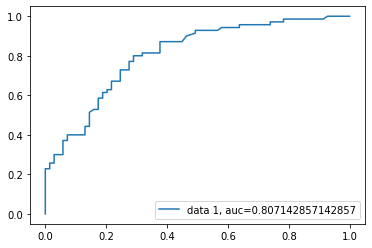

In [ ]:
# plot ROC curve
import matplotlib.pyplot as plt
y_pred_proba = lg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# print classification report
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73        69
         1.0       0.73      0.77      0.75        70

    accuracy                           0.74       139
   macro avg       0.74      0.74      0.74       139
weighted avg       0.74      0.74      0.74       139



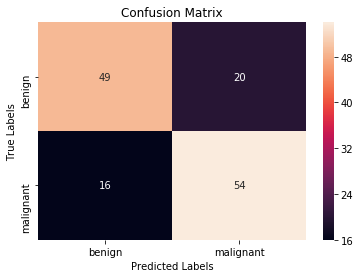

In [ ]:
# print confusion matrix
cm = confusion_matrix(y_test, y_pred_lg)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['benign', 'malignant']); ax.yaxis.set_ticklabels(['benign', 'malignant']);

### b. Random Forest

In [ ]:
# build random forest model
from sklearn.ensemble import RandomForestClassifier
seed=1

param_grid = {'n_estimators': [20, 40, 60, 80, 100], 'max_depth': [2, 5, None]}
rf=RandomForestClassifier(random_state=seed)
rf_cv=GridSearchCV(rf,param_grid,cv=5)
rf_cv.fit(X_train,y_train)

rf = rf_cv.best_estimator_ 
rf.fit(X_train, y_train)  
y_pred_rf = rf.predict(X_test)

# print info about the best-performing model
print("Random Forest Best Parameters: ",rf_cv.best_params_)
print("Random Forest Best Estimator: ",rf_cv.best_estimator_)

Random Forest Best Parameters:  {'max_depth': 2, 'n_estimators': 100}
Random Forest Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


In [ ]:
# evaluate accuracy, variance and bias issues

# compute RSME of training set
y_pred_rf_train = rf.predict(X_train)
RMSE_train_rf = (MSE(y_train, y_pred_rf_train))**(1/2)

# compute CV RMSE of training set
MSE_CV_rf_scores = - cross_val_score(rf, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
RMSE_CV_rf = (MSE_CV_rf_scores.mean())**(1/2)

# compute RMSE of test set
mse_rf = MSE(y_test, y_pred_rf)
rmse_rf = mse_rf**(1/2)

print("Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
print('Train RMSE of Random Forest: {:.2f}'.format(RMSE_train_rf))
print('CV RMSE of Random Forest: {:.2f}'.format(RMSE_CV_rf))
print("Test set RMSE of Random Forest: {:.2f}".format(rmse_rf))

Random Forest Accuracy: 0.762589928057554
Train RMSE of Random Forest: 0.50
CV RMSE of Random Forest: 0.53
Test set RMSE of Random Forest: 0.49


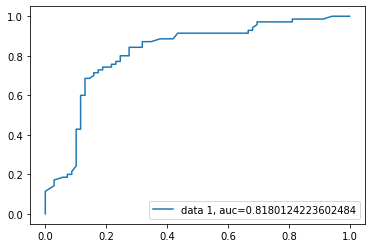

In [ ]:
# plot ROC curve
import matplotlib.pyplot as plt
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# print classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.78      0.72      0.75        69
         1.0       0.75      0.80      0.77        70

    accuracy                           0.76       139
   macro avg       0.76      0.76      0.76       139
weighted avg       0.76      0.76      0.76       139



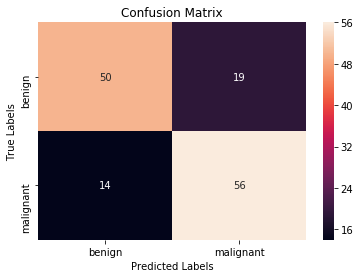

In [ ]:
# print confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['benign', 'malignant']); ax.yaxis.set_ticklabels(['benign', 'malignant']);

### c. SVM

In [ ]:
# build SVM model
from sklearn.svm import SVC 

param_grid = {'C': [0.01, 0.06, 0.08, 1., 3.], 'gamma': [0.01, 0.1, 1., 10., 100]}
svm=SVC(kernel='rbf', probability=True)
svm_cv=GridSearchCV(svm,param_grid,cv=5)
svm_cv.fit(X_train,y_train)

svm = svm_cv.best_estimator_ 
svm.fit(X_train, y_train)  
y_pred_svm = svm.predict(X_test)

# print info about the best-performing model
print("SVM Best Parameters: ",lg_cv.best_params_)
print("SVM Best Estimator: ",lg_cv.best_estimator_)

SVM Best Parameters:  {'C': 3.0, 'penalty': 'l2'}
SVM Best Estimator:  LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
# evaluate accuracy, variance and bias issues

# compute RSME of training set
y_pred_svm_train = svm.predict(X_train)
RMSE_train_svm = (MSE(y_train, y_pred_svm_train))**(1/2)

# compute CV RMSE of training set
MSE_CV_svm_scores = - cross_val_score(svm, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
RMSE_CV_svm = (MSE_CV_svm_scores.mean())**(1/2)

# compute RMSE of test set
mse_svm = MSE(y_test, y_pred_svm)
rmse_svm = mse_svm**(1/2)

print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))
print('Train RMSE of SVM: {:.2f}'.format(RMSE_train_svm))
print('CV RMSE of SVM: {:.2f}'.format(RMSE_CV_svm))
print("Test set RMSE of SVM: {:.2f}".format(rmse_svm))

SVM Accuracy: 0.7338129496402878
Train RMSE of SVM: 0.49
CV RMSE of SVM: 0.50
Test set RMSE of SVM: 0.52


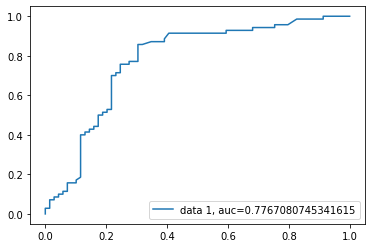

In [ ]:
# plot ROC curve
import matplotlib.pyplot as plt
y_pred_proba = svm.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# print classification report
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.75      0.70      0.72        69
         1.0       0.72      0.77      0.74        70

    accuracy                           0.73       139
   macro avg       0.73      0.73      0.73       139
weighted avg       0.73      0.73      0.73       139



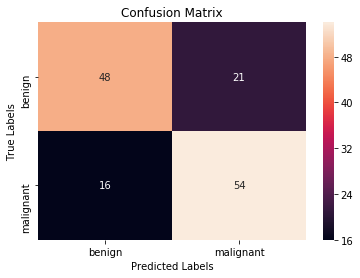

In [ ]:
# print confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['benign', 'malignant']); ax.yaxis.set_ticklabels(['benign', 'malignant']);